# Estimate the amount of missing data in individual feature tables and impute with K-Nearest Neighbors

In [1]:
#!/usr/bin/env python3
import os, joblib
import datatable as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.impute import KNNImputer

os.chdir('/home/seguraab/ara-kinase-prediction/data/Features')

# Make a directory to save imputed feature tables to
if not os.path.exists('imputed_features'):
    os.makedirs('imputed_features')

if not os.path.exists('../../output/3_imputation'):
    os.makedirs('../../output/3_imputation')

# Load in all the feature tables
epi_df = dt.fread('epigenetics_gene_pairs_features.csv').to_pandas().\
    set_index(['gene1', 'gene2'])
evo_df = dt.fread('evolutionary_properties_gene_pairs_features.txt').\
    to_pandas().set_index(['gene1', 'gene2'])
expr_df = dt.fread('gene_expression_gene_pairs_features.csv').to_pandas().\
    set_index(['gene1', 'gene2'])
func_df = dt.fread('functional_annotations_gene_pairs_features.txt').\
    to_pandas().set_index(['gene1', 'gene2'])
net_df = dt.fread('network_properties_gene_pairs_features.csv').to_pandas().\
    set_index(['gene1', 'gene2'])
prot_files = [f for f in os.listdir('.') if f.startswith('protein_properties')]
prot_df = pd.concat(
    [dt.fread(f).to_pandas().set_index(['gene1', 'gene2']) for f in prot_files],
    ignore_index=False, axis=1)

### Save a file with the percent missing data in each feature table

In [2]:
pd.set_option('display.max_rows', None)
# Determine the percent missing data in each feature table
missing = pd.concat([epi_df.isna().sum() / epi_df.shape[0] * 100,
    evo_df.isna().sum() / evo_df.shape[0] * 100,
    expr_df.isna().sum() / expr_df.shape[0] * 100,
    func_df.isna().sum() / func_df.shape[0] * 100,
    net_df.isna().sum() / net_df.shape[0] * 100,
    prot_df.isna().sum() / prot_df.shape[0] * 100], axis=0)

# add which dataset the rows in missing belong to
missing = pd.DataFrame(missing, columns=['percent_missing'])
missing['dataset'] = ['epigenetics'] * epi_df.shape[1] + \
    ['evolutionary'] * evo_df.shape[1] + \
    ['gene_expression'] * expr_df.shape[1] + \
    ['functional_annotations'] * func_df.shape[1] + \
    ['network_properties'] * net_df.shape[1] + \
    ['protein_properties'] * prot_df.shape[1]

# missing.sort_values(by='percent_missing', ascending=False).to_csv(
# 	'imputed_features/0_percent_missing_data.csv')
print(missing.loc[missing.percent_missing==0.0,:]).shape # (1204, 2)
missing.groupby('dataset').value_counts()

dataset                 percent_missing
epigenetics             0.000000            333
                        57.619512             8
                        73.365854             8
                        88.517073             8
                        90.478049             8
                        91.190244             8
                        91.375610             8
                        91.736585             8
                        95.775610             8
                        96.175610             8
                        97.629268             8
                        3.346341              6
                        3.619512              6
                        4.302439              6
                        4.360976              6
                        4.439024              6
                        7.092683              6
                        7.551220              6
                        27.014634             6
                        47.434146             6


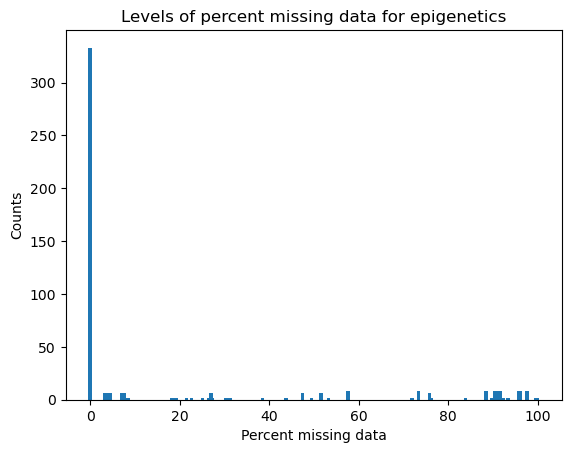

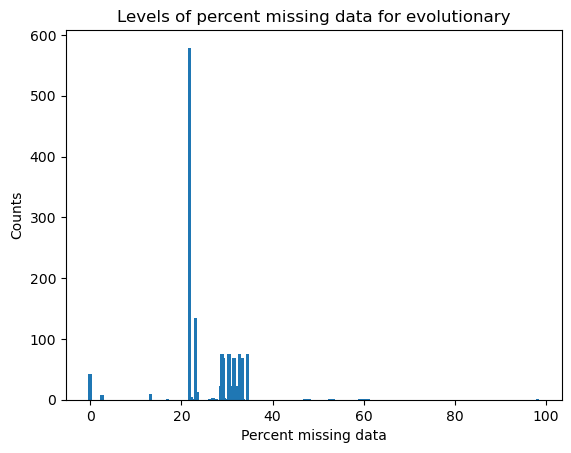

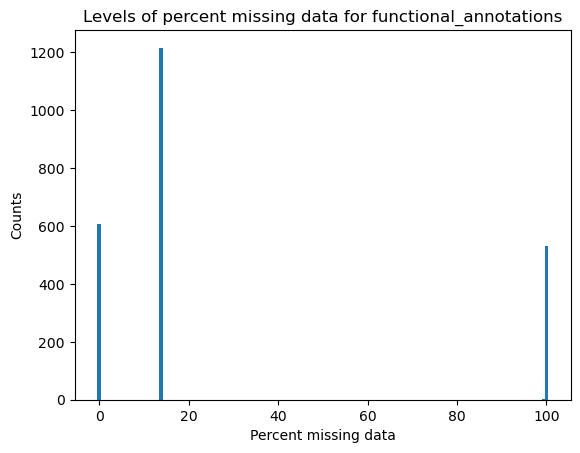

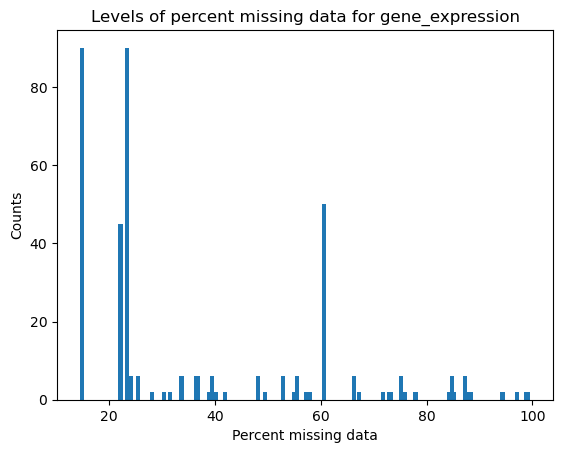

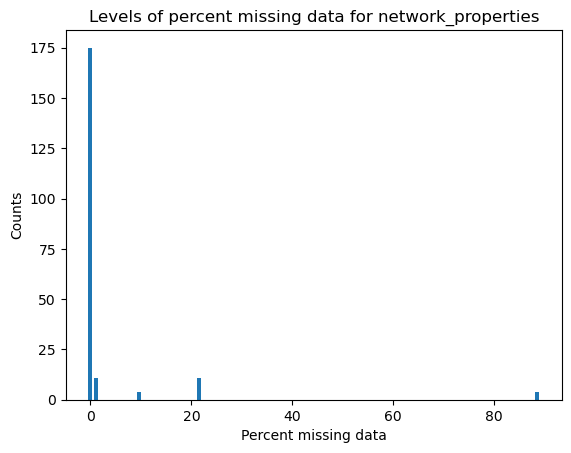

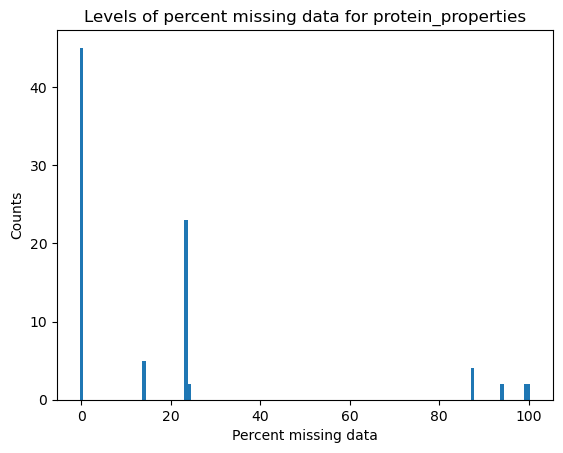

In [3]:
# Levels of missing data in each dataset
for dataset, group in missing.groupby('dataset'):
    counts = group.value_counts()
    plt.bar(counts.index.get_level_values(0), height=counts)
    plt.title(f'Levels of percent missing data for {dataset}')
    plt.xlabel('Percent missing data')
    plt.ylabel('Counts')
    plt.show()

### Func_df pre-imputation processing
- Remove columns with infinitie values
- Remove columns with only zeroes and/or NaN values
- Keep only the columns with ~13% missing data -- these will be imputed.

In [4]:
# Drop columns in func_df that only have infinite values
inf_cols = func_df.columns.to_series()[np.isinf(func_df).any(axis=0)] # 608 columns
print(func_df.shape) # (10250, 2432)
func_df.drop(inf_cols, axis=1, inplace=True)
print(func_df.shape) # (10250, 1824)

# Drop columns that only have 0 and/or NaN values
zero_cols = []
for col in func_df.columns:
    counts = func_df[col].value_counts()
    if (counts.shape[0] < 2):
        if counts.shape[0] == 0:
            zero_cols.append(col)
        elif 0.0 in counts.index:
            zero_cols.append(col)

func_df.drop(zero_cols, axis=1, inplace=True)
print(func_df.shape) # (10250, 228)
func_na_counts = pd.Series(func_df.isna().sum()/func_df.shape[0]).value_counts()
print(func_na_counts)

# Impute the columns with ~13% missing data
keep = func_df.isna().sum()/func_df.shape[0] < 0.14
func_df = func_df.loc[:,keep[keep==True].index]
func_df.shape # (10250, 152)
# func_df.to_csv('imputed_features/functional_annotations_gene_pairs_features_13%_missing.csv')

0.138829    152
0.999902     48
0.999805     16
0.999707      4
0.994049      2
0.996390      2
0.997756      1
0.998244      1
0.998341      1
0.999024      1
Name: count, dtype: int64


(10250, 152)

# Impute Missing Data
KNN Imputer will be trained on the training set only for individual feature datasets.
The fitted model will then be used to transform the testing set.
Before KNN Imputer can be implemented, I must determine the optimal k-value for each dataset.

Since there are 6 feature categories * 10 test sets = 60 imputation models will be trained on a subset of Melissa's Arabidopsis duplicate gene pairs.

In [5]:
def impute_missing(X, k):
    '''Instantiate a K-Nearest Neighbors imputer and apply it to data X'''
    imputer = KNNImputer(n_neighbors=k, weights="distance")
    mod = imputer.fit(X)
    imputed = mod.transform(X)
    imputed = pd.DataFrame(imputed, index=X.index, columns=X.columns)
    return imputed, mod

In [6]:
# Prepare the labels and test set files
y = pd.read_csv('../20240725_melissa_ara_data/interactions_fitness_labels.csv', index_col=0) # Melissa's gene pair labels
y.reset_index(inplace=True)
y.drop_duplicates(inplace=True)
y.set_index('index', inplace=True)
test_files = [f for f in os.listdir('../test_sets_clf/') if f.startswith('test')] # test set files

# Determine what is the optimal k-value for imputing individual datasets
func_df = pd.read_csv('imputed_features/functional_annotations_gene_pairs_features_13%_missing.csv', index_col=[0,1])
datasets = [('epigenetics', epi_df), ('evolutionary_properties', evo_df),
            ('gene_expression', expr_df), ('network_properties', net_df),
            ('protein_properties', prot_df), ('functional_annotations', func_df)]
results = []
for name, X in datasets:
    print(X.shape)
    X = X.reset_index()
    X.index = np.sort(X[['gene1', 'gene2']], axis=1) # sort the gene pairs
    X.index = X.index.map(tuple) # convert to tuples
    X.index = X.index.map(lambda x: x[0] + '_' + x[1]) # convert to strings
    X.drop(['gene1', 'gene2'], axis=1, inplace=True)
    X_train = X.loc[y.index,:] # Melissa's gene pairs only
    
    # drop features with >= 30% missing data
    X_train = X_train.loc[:, X.isna().sum()/X.shape[0] < 0.3]
    print("Infinite values?", np.isinf(X_train).sum().sum())
    
    # Keep only the training data
    for test in test_files:
        test_df = pd.read_csv(f'../test_sets_clf/{test}', header=None)
        X_train_sub = X_train.loc[~y.index.isin(test_df[0]),:] # training gene pairs only
        print(X_train_sub.shape)
        print(X_train_sub.dtypes.value_counts())
        
        # Test out different n_neighbors values
        best_score = -1
        best_k = 0
        for k in range(3, 20):
            imputer = KNNImputer(n_neighbors=k, weights="distance", add_indicator=True)
            mod = make_pipeline(imputer, MinMaxScaler(), LogisticRegression(max_iter=100))
            scores = cross_val_score(mod, X_train_sub,
                y.loc[X_train_sub.index,:].squeeze(), cv=5,
                error_score='raise').mean()
            
            if scores > best_score:
                best_score = scores
                best_k = k
        
        results.append({'name': name, 'test': test, 'best_k': best_k,
                        'best_score': best_score})
        del X_train_sub
    del X
    
'''The above code runs, but I'm getting a strange warning that I don't know how
to fix:
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88:
RuntimeWarning: invalid value encountered in reduce
return ufunc.reduce(obj, axis, dtype, out, **passkwargs)

Co-pilot said it could be the presence of infinite values, but there are none.
This error has to be tied to the Logistic regression iterations, since it gets
printed many many times.

Either way, I'm going to use the results to select the k-values for KNNImputer.
'''

# pd.DataFrame(results).to_csv('../../output/3_imputation/best_k_values_for_imputation.csv', index=False)

(10250, 565)
Infinite values? 0
(113, 413)
float64    308
bool        62
int32       43
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(113, 413)
float64    308
bool        62
int32       43
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(112, 413)
float64    308
bool        62
int32       43
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(112, 413)
float64    308
bool        62
int32       43
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(113, 413)
float64    308
bool        62
int32       43
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(112, 413)
float64    308
bool        62
int32       43
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(112, 413)
float64    308
bool        62
int32       43
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(113, 413)
float64    308
bool        62
int32       43
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(112, 413)
float64    308
bool        62
int32       43
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(113, 413)
float64    308
bool        62
int32       43
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(10250, 1580)
Infinite values? 0
(113, 1130)
float64    1119
bool          6
int32         5
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(113, 1130)
float64    1119
bool          6
int32         5
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(112, 1130)
float64    1119
bool          6
int32         5
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(112, 1130)
float64    1119
bool          6
int32         5
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(113, 1130)
float64    1119
bool          6
int32         5
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(112, 1130)
float64    1119
bool          6
int32         5
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(112, 1130)
float64    1119
bool          6
int32         5
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(113, 1130)
float64    1119
bool          6
int32         5
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(112, 1130)
float64    1119
bool          6
int32         5
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(113, 1130)
float64    1119
bool          6
int32         5
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(10250, 450)
Infinite values? 0
(113, 284)
float64    284
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(113, 284)
float64    284
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(112, 284)
float64    284
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(112, 284)
float64    284
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(113, 284)
float64    284
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(112, 284)
float64    284
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(112, 284)
float64    284
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(113, 284)
float64    284
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(112, 284)
float64    284
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(113, 284)
float64    284
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(10250, 205)
Infinite values? 0
(113, 201)
bool       175
float64     26
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(113, 201)
bool       175
float64     26
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(112, 201)
bool       175
float64     26
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(112, 201)
bool       175
float64     26
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(113, 201)
bool       175
float64     26
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(112, 201)
bool       175
float64     26
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(112, 201)
bool       175
float64     26
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(113, 201)
bool       175
float64     26
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(112, 201)
bool       175
float64     26
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(113, 201)
bool       175
float64     26
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(10250, 93)
Infinite values? 0
(113, 79)
float64    68
int32      11
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(113, 79)
float64    68
int32      11
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(112, 79)
float64    68
int32      11
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(112, 79)
float64    68
int32      11
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(113, 79)
float64    68
int32      11
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(112, 79)
float64    68
int32      11
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(112, 79)
float64    68
int32      11
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(113, 79)
float64    68
int32      11
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(112, 79)
float64    68
int32      11
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

(113, 79)
float64    68
int32      11
Name: count, dtype: int64


/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(ob

"The above code runs, but I'm getting a strange warning that I don't know how\nto fix:\n/home/seguraab/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88:\nRuntimeWarning: invalid value encountered in reduce\nreturn ufunc.reduce(obj, axis, dtype, out, **passkwargs)\n\nCo-pilot said it could be the presence of infinite values, but there are none.\nThis error has to be tied to the Logistic regression iterations, since it gets\nprinted many many times.\n\nEither way, I'm going to use the results to select the k-values for KNNImputer.\n"

In [1]:
def run_imputation(df_path, row):
    '''Impute the missing values for Melissa's gene pairs using KNNImputer.'''
    # train-test split
    test_df = pd.read_csv(f'../test_sets_clf/{row.test}', header=None)
    if row['name'] != 'protein_properties':
        df = dt.fread(df_path).to_pandas().set_index(['gene1', 'gene2'])
    else:
        df_files = [f for f in os.listdir('.') if f.startswith('protein_properties')]
        df = pd.concat([dt.fread(f).to_pandas().\
                        set_index(['gene1', 'gene2']) for f in df_files],
                        ignore_index=False, axis=1)
    df.index = df.index.map(lambda x: '_'.join(x))
    df_train = df.loc[(~df.index.isin(test_df[0])) & (df.index.isin(y.index)),:]
    df_test = df.loc[df.index.isin(test_df[0]),:]
    
    # drop features with > 30% missing data
    df_train = df_train.loc[:, df.isna().sum()/df.shape[0] < 0.3]
    df_test = df_test.loc[:, df_train.columns]
    
    # impute missing data in each feature table
    df_train = df_train.astype({col: 'int' for col in df_train.columns if df_train[col].dtype == 'bool'})
    # df_train.info() # make sure bool columns are now int
    imp_train, mod = impute_missing(df_train, row.best_k)
    imp_train.to_csv(f"imputed_features/{row['name']}_{row.test.replace('.txt','')}_imputed_train.csv")
    joblib.dump(mod, f"imputed_features/{row['name']}_{row.test.replace('.txt','')}_imputer_train.joblib")
    imp_test = mod.transform(df_test)
    imp_test = pd.DataFrame(imp_test, index=df_test.index, columns=df_test.columns)
    imp_test.to_csv(f"imputed_features/{row['name']}_{row.test.replace('.txt','')}_imputed_test.csv")
    del df_train, df_test, imp_train, imp_test, mod

In [ ]:
k_vals = pd.read_csv('../../output/3_imputation/best_k_values_for_imputation.csv')
for i,row in k_vals.iterrows():
    print(i, row)
    if row['name'] == 'epigenetics':
        run_imputation('epigenetics_gene_pairs_features.csv', row)
    elif row['name'] == 'evolutionary_properties':
        run_imputation('evolutionary_properties_gene_pairs_features.txt', row)
    elif row['name'] == 'gene_expression':
        run_imputation('gene_expression_gene_pairs_features.csv', row)
    elif row['name'] == 'network_properties':
        run_imputation('network_properties_gene_pairs_features.csv', row)
    elif row['name'] == 'protein_properties':
        run_imputation('', row)
    elif row['name'] == 'functional_annotations':
        run_imputation('imputed_features/functional_annotations_gene_pairs_features_13%_missing.csv', row)